# Download data and have a quick look

In [5]:
!unzip data.zip

Archive:  data.zip
   creating: Dataset/
  inflating: Dataset/Train.csv       
  inflating: Dataset/sample_submission.csv  
  inflating: Dataset/Test.csv        


In [6]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path('/content/Dataset')

train_data = pd.read_csv(DATA_PATH/'Train.csv', index_col=0, infer_datetime_format=True, converters={'DATE':pd.to_datetime})
train_data.head()

,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
INCIDENT_ID,,,,,,,,,,,,,,,,,
CR_102659,2004-07-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
CR_189752,2017-07-18,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
CR_184637,2017-03-15,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
CR_139071,2009-02-13,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
CR_109335,2005-04-13,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


Since there are no named features we cannot do some domain specific feature engineering.

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23856 entries, CR_102659 to CR_22575
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              23856 non-null  datetime64[ns]
 1   X_1               23856 non-null  int64         
 2   X_2               23856 non-null  int64         
 3   X_3               23856 non-null  int64         
 4   X_4               23856 non-null  int64         
 5   X_5               23856 non-null  int64         
 6   X_6               23856 non-null  int64         
 7   X_7               23856 non-null  int64         
 8   X_8               23856 non-null  int64         
 9   X_9               23856 non-null  int64         
 10  X_10              23856 non-null  int64         
 11  X_11              23856 non-null  int64         
 12  X_12              23674 non-null  float64       
 13  X_13              23856 non-null  int64         
 14  X_14            

There are some null or nan values in `X_12`

# Correlation of variables

In [0]:
corr = train_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
X_1,1.000000,0.021999,0.022603,0.002137,-0.034220,0.409876,0.421454,-0.061897,0.017984,0.004155,-0.003078,-0.034835,0.111611,-0.012708,-0.012132,0.014034
X_2,0.021999,1.000000,0.996985,-0.104321,-0.349190,0.119718,0.058806,-0.038174,-0.017749,-0.016710,0.038003,-0.067720,0.046668,0.015194,0.013822,-0.027293
X_3,0.022603,0.996985,1.000000,-0.075344,-0.347519,0.124662,0.072954,-0.033035,-0.019853,-0.014485,0.036946,-0.064872,0.043201,0.013522,0.006851,-0.027218
X_4,0.002137,-0.104321,-0.075344,1.000000,0.439616,0.028929,0.094076,0.075197,-0.008453,0.038077,-0.037614,0.059135,-0.051861,-0.030024,-0.033198,-0.002921
X_5,-0.034220,-0.349190,-0.347519,0.439616,1.000000,-0.062784,0.010161,0.046926,0.046428,0.046212,-0.043111,0.082068,-0.071233,-0.003413,-0.036383,-0.003450
X_6,0.409876,0.119718,0.124662,0.028929,-0.062784,1.000000,0.695243,-0.063541,0.079192,0.021186,-0.002990,-0.031258,0.047845,-0.013155,-0.006621,-0.007903
X_7,0.421454,0.058806,0.072954,0.094076,0.010161,0.695243,1.000000,-0.011824,0.011519,0.023205,0.002970,-0.000409,0.012204,0.003738,-0.003277,-0.008036
X_8,-0.061897,-0.038174,-0.033035,0.075197,0.046926,-0.063541,-0.011824,1.000000,-0.090184,0.222004,0.009424,0.273107,-0.048140,0.003987,0.017636,-0.033397
X_9,0.017984,-0.017749,-0.019853,-0.008453,0.046428,0.079192,0.011519,-0.090184,1.000000,0.013388,-0.006152,0.005150,0.023537,-0.297295,0.006475,-0.000748
X_10,0.004155,-0.016710,-0.014485,0.038077,0.046212,0.021186,0.023205,0.222004,0.013388,1.000000,-0.045596,0.877743,0.002332,-0.016519,-0.003336,-0.242596


The highest **negative** correlation for the target variable is `X_10` and the higihest **positive** correlation is with `X_15`.

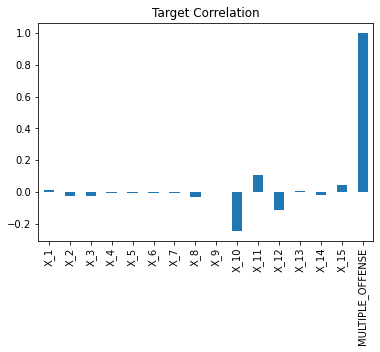

In [0]:
mul_off = train_data['MULTIPLE_OFFENSE']
corr = train_data.corrwith(mul_off)
corr.plot(kind='bar', title='Target Correlation')

# Target Distribution

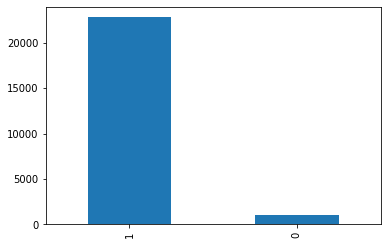

In [5]:
train_data['MULTIPLE_OFFENSE'].value_counts().plot(kind='bar')

We have quite a skewed distribution, maybe now we can have make an assumption regarding what the classes of `MULTIPLE_OFFENSE` may mean, the problem title was **Predict if the server will be hacked**, assuming some normal conditions

- `1` must be the times when the server was not attacked and running smoothly
- `0` must be the times when the server was attacked and malfunctioning(maybe)

To understand the feature interaction we can try to build a simple decision tree classifier and plot the decision tree to view interaction visually. We should also consider this problem as a time-series classification problem.

# Model setup

In [0]:
# since we may need the model to work on data with proper sequence
train_data.sort_values(by='DATE', inplace=True)

In [0]:
import numpy as np
seed=0
np.random.seed(seed=seed)

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# form a pipeline with scaler and decision tree
pipe = Pipeline([
                 ('median_imputer', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()),
                 ('tree', DecisionTreeClassifier(max_depth=4, random_state=seed))
                 ])

# Data Preprocessing

In [0]:
from sklearn.model_selection import train_test_split

# We will try not to use dates now
x_train, x_test, y_train, y_test = train_test_split(train_data.drop(['DATE', 'MULTIPLE_OFFENSE'], axis='columns'), 
                                                    train_data['MULTIPLE_OFFENSE'],
                                                    random_state=seed,
                                                    # Stratified split
                                                    stratify=train_data['MULTIPLE_OFFENSE'].values)

In [140]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17892, 15), (17892,), (5964, 15), (5964,))

# Model Training

In [141]:
pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('median_imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=4,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=0,
                                   

# Model Evaluation

In [142]:
pipe.score(x_test, y_test)

0.9842387659289068

This might be misleading because our target is heavily skewed towards `1`

In [0]:
y_pred = pipe.predict(x_test)

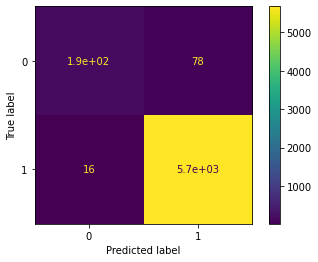

In [144]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe, x_test, y_test)

In [145]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'TP = {tp} \nFP = {fp}\nTN = {tn}\nFN = {fn}')

TP = 5681 
FP = 78
TN = 189
FN = 16


In [146]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names = ['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.92      0.71      0.80       267
     class 1       0.99      1.00      0.99      5697

    accuracy                           0.98      5964
   macro avg       0.95      0.85      0.90      5964
weighted avg       0.98      0.98      0.98      5964



Not bad at all, but based on our assumption if we assume that the classes represent

- `1` must be the times when the server was not attacked and running smoothly
- `0` must be the times when the server was attacked and malfunctioning(maybe)

The model will be more useful if it could predict the malfunction correctly most of the times because it should be able to detect the fault.


The `FP (False Positives)` *(ie)* the number of cases where the server was malfunctioning but the model predicted as **not** is **`78`**, not bad actually.


If we look at the value of `recall` for `class 0` it is `0.71` which is okay for a simple decision tree classifier, with no feature engineering.

Let's try to plot the tree

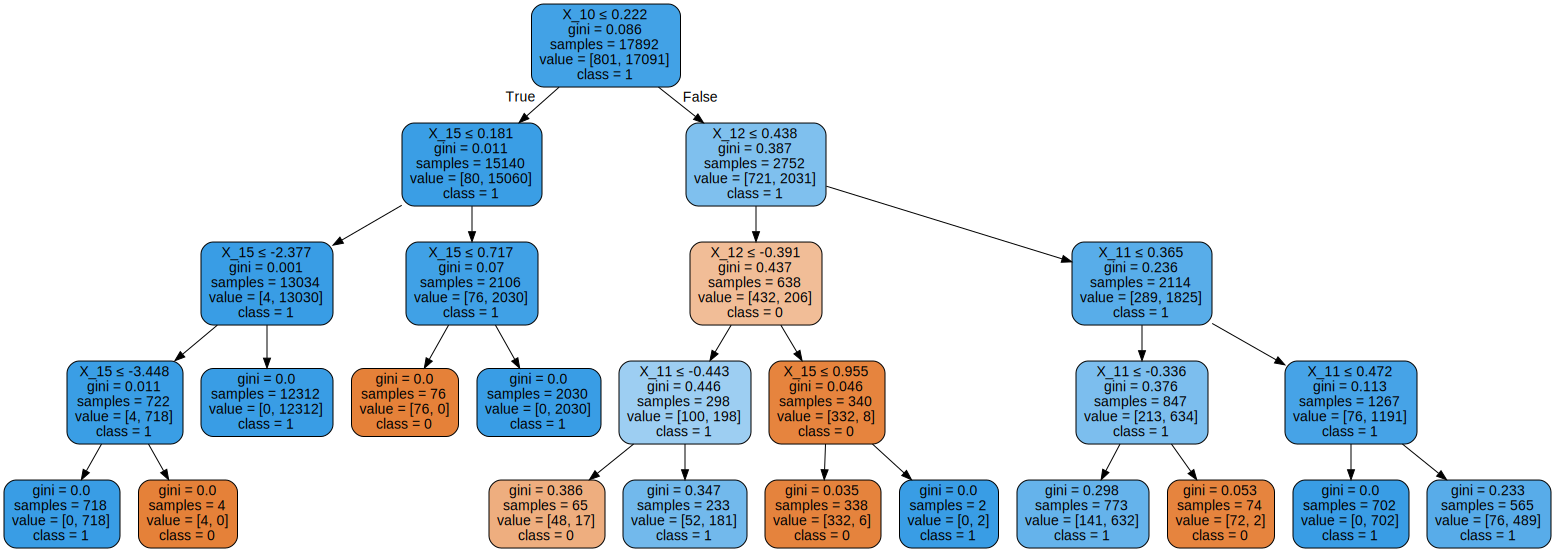

In [160]:
from sklearn import tree
import graphviz

# tree.plot_tree(pipe['tree'])
dot_data = tree.export_graphviz(pipe['tree'], out_file=None, 
                     feature_names=[f'X_{i}' for i in range(1, 16)],  
                     class_names=['0', '1'],  
                     filled=True, rounded=True,  
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [161]:
graph.render("server_mal")

'server_mal.pdf'

According the decision tree the most important features are `X_10`, `X_11`, `X_12` and `X_15`.

## Prediction on test data

In [150]:
test_data = pd.read_csv(DATA_PATH/'Test.csv', index_col=0)
test_data.head()

,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
INCIDENT_ID,,,,,,,,,,,,,,,,
CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


We used only the logging parameters of the server to model the decision tree so we don't need other variables.

In [0]:
test_data.drop('DATE', axis='columns', inplace=True)

In [0]:
y_pred = pipe.predict(test_data)

In [157]:
sub_df = pd.DataFrame(
    {'INCIDENT_ID':test_data.index,
     'MULTIPLE_OFFENSE':y_pred},
     )
sub_df.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [0]:
sub_df.to_csv('submission_df.csv', index=False)

This submission scored a decent `85` (recall) on the test set, but it can be improved further.

## Model Persistence

In [26]:
!pip list | egrep 'scikit-learn|pandas'

pandas                   1.0.4          
pandas-datareader        0.8.1          
pandas-gbq               0.11.0         
pandas-profiling         1.4.1          
scikit-learn             0.22.2.post1   
sklearn-pandas           1.8.0          


In [0]:
import joblib

with open('desc_pipeline.joblib', 'wb') as f:joblib.dump(pipe, f)

In [163]:
!zip eda_model_interp.zip server_mal.pdf desc_pipeline.joblib

updating: server_mal.pdf (deflated 8%)
updating: desc_pipeline.joblib (deflated 48%)
